# Putting It All Together
> A Summary of lecture "Time Series Analysis in Python", via datacamp

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Datacamp, Time_Series_Analysis]
- image: images/tavg_predict.png

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = (10, 5)

## Cointegration Models
- What is Cointegration?
    - Two series, $P_t$ and $Q_t$ can be random walks
    - But the linear combination $P_t - c Q_t$ may not be a random walk!
    - If that's true
        - $P_t - c Q_t$ is forecastable
        - $P_t$ and $Q_t$ are said to be cointegrated
- Analogy: Dog on a Leash
    - $P_t =$ Owner
    - $Q_t =$ Dog
    - Both series look like a random walk
    - Difference of distance between them, looks mean reverting
        - If dog falls too far behind, it gets pulled forward
        - If dog gets too far ahead, it gets pulled back
- What types of series are cointegrated?
    - Economic substitutes
        - Heating Oil and Natural Gas
        - Platinum and Palladium
        - Corn and Wheat
        - Corn and Sugar
        - $\dots$
        - Bitcoin and Ethereum
- Two steps to test for Cointegration
    - Regress $P_t$ on$Q_t$ and get slope $c$
    - Run Augmented Dickey-Fuller test on $P_t - c Q_t$ to test for random walk
    - Alternatively, can use ```coint``` function in statsmodels that combines both steps

### A Dog on a Leash? (Part 1)
The Heating Oil and Natural Gas prices are pre-loaded in DataFrames HO and NG. First, plot both price series, which look like random walks. Then plot the difference between the two series, which should look more like a mean reverting series (to put the two series in the same units, we multiply the heating oil prices, in $/gallon, by 7.25, which converts it to $/millionBTU, which is the same units as Natural Gas).

The data for continuous futures (each contract has to be spliced together in a continuous series as contracts expire) was obtained from [Quandl](https://blog.quandl.com/api-for-futures-data).

- Preprocess

In [2]:
HO = pd.read_csv('./dataset/CME_HO1.csv', index_col=0)
NG = pd.read_csv('./dataset/CME_NG1.csv', index_col=0)

In [3]:
HO.index = pd.to_datetime(HO.index, format='%m/%d/%Y')
NG.index = pd.to_datetime(NG.index, format='%m/%d/%Y')

In [4]:
HO = HO.sort_index()
NG = NG.sort_index()

In [5]:
HO.head()

Close
Date              
1991-01-02  0.7330
1991-01-03  0.7024
1991-01-04  0.6830
1991-01-07  0.7617
1991-01-08  0.7430

In [6]:
NG.head()

Close
Date             
1991-01-02  1.832
1991-01-03  1.782
1991-01-04  1.743
1991-01-07  1.785
1991-01-08  1.786

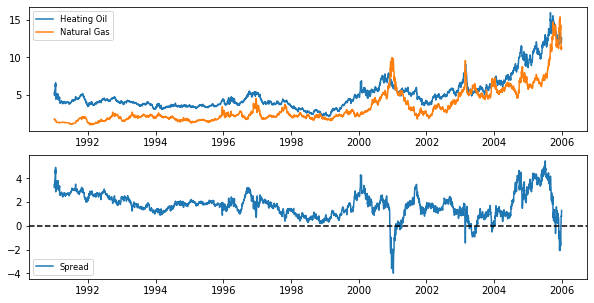

In [7]:
# Plot the prices separately
plt.subplot(2, 1, 1)
plt.plot(7.25 * HO, label='Heating Oil');
plt.plot(NG, label='Natural Gas');
plt.legend(loc='best', fontsize='small');

# Plot the spread
plt.subplot(2, 1, 2)
plt.plot(7.25 * HO - NG, label='Spread');
plt.legend(loc='best', fontsize='small');
plt.axhline(y=0, linestyle='--', color='k');

### A Dog on a Leash? (Part 2)
To verify that Heating Oil and Natural Gas prices are cointegrated, First apply the Dickey-Fuller test separately to show they are random walks. Then apply the test to the difference, which should strongly reject the random walk hypothesis. 

In [8]:
from statsmodels.tsa.stattools import adfuller

# Compute the ADF for HO and NG
result_HO = adfuller(HO['Close'])
print("The p-value for the ADF test on HO is ", result_HO[1])
result_NG = adfuller(NG['Close'])
print("The p-value for the ADF test on NG is ", result_NG[1])

# Compute the ADF of the spread
result_spread = adfuller(7.25 * HO['Close'] - NG['Close'])
print("The p-value for the ADF test on the spread is ", result_spread[1])

The p-value for the ADF test on HO is  0.956710878501786
The p-value for the ADF test on NG is  0.9008747444676729
The p-value for the ADF test on the spread is  7.019439302142287e-05


### Are Bitcoin and Ethereum Cointegrated?
Cointegration involves two steps: regressing one time series on the other to get the cointegration vector, and then perform an ADF test on the residuals of the regression. In the last example, there was no need to perform the first step since we implicitly assumed the cointegration vector was (1,−1). In other words, we took the difference between the two series (after doing a units conversion). Here, you will do both steps.

You will regress the value of one cryptocurrency, bitcoin (BTC), on another cryptocurrency, ethereum (ETH). If we call the regression coefficient b, then the cointegration vector is simply (1,−b). Then perform the ADF test on BTC −b ETH. 

- Preprocess

In [9]:
BTC = pd.read_csv('./dataset/BTC.csv', index_col=0)
ETH = pd.read_csv('./dataset/ETH.csv', index_col=0)

In [10]:
BTC.index = pd.to_datetime(BTC.index, format='%Y-%m-%d')
ETH.index = pd.to_datetime(ETH.index, format='%Y-%m-%d')

In [11]:
import statsmodels.api as sm

# Regress BTC on ETH
ETH = sm.add_constant(ETH)
result = sm.OLS(BTC, ETH).fit()

# Compare ADF
b = result.params[1]
adf_stats = adfuller(BTC['Price'] - b * ETH['Price'])
print("The p-value for the ADF test is ", adf_stats[1])

The p-value for the ADF test is  0.02336900232347285


## Case Study: Climate Change


### Is Temperature a Random Walk (with Drift)?
An ARMA model is a simplistic approach to forecasting climate changes, but it illustrates many of the topics covered in this class.

The DataFrame ```temp_NY``` contains the average annual temperature in Central Park, NY from 1870-2016 (the data was downloaded from the NOAA [here](https://www.ncdc.noaa.gov/cdo-web/search)). Plot the data and test whether it follows a random walk (with drift).

- Preprocess

In [12]:
temp_NY = pd.read_csv('./dataset/NOAA_TAVG.csv', index_col=0)
temp_NY.index = pd.to_datetime(temp_NY.index, format='%Y')
temp_NY.head()

TAVG
DATE            
1870-01-01  53.8
1871-01-01  51.3
1872-01-01  51.3
1873-01-01  50.9
1874-01-01  51.3

The p-value for the ADF test is  0.583293898787112


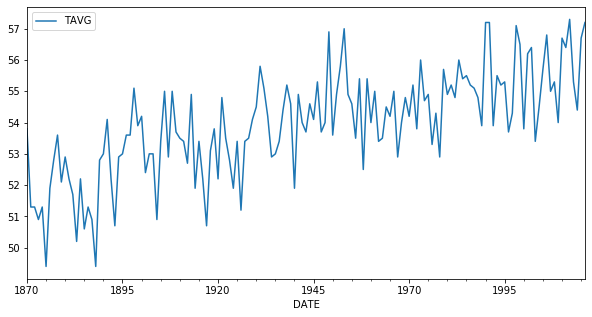

In [13]:
# Plot average temperatures
temp_NY.plot();

# Compute and print ADF p-value
result = adfuller(temp_NY['TAVG'])
print("The p-value for the ADF test is ", result[1])

### Getting "Warmed" Up: Look at Autocorrelations
Since the temperature series, ```temp_NY```, is a random walk with drift, take first differences to make it stationary. Then compute the sample ACF and PACF. This will provide some guidance on the order of the model.

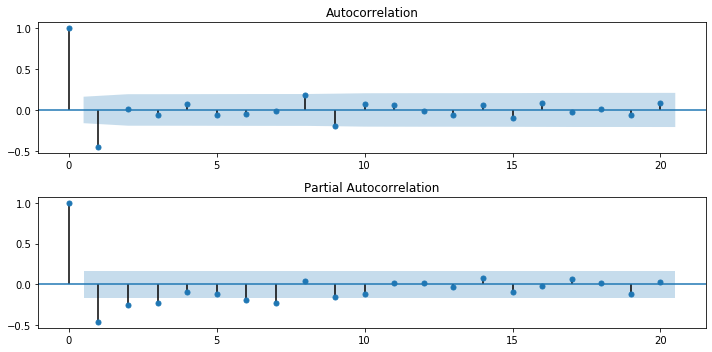

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Take first difference of the temperature Series
chg_temp = temp_NY.diff()
chg_temp = chg_temp.dropna()

# Plot the ACF and PACF on the same page
fig, axes = plt.subplots(2, 1)

# Plot the ACF
plot_acf(chg_temp, lags=20, ax=axes[0]);

# Plot the PACF
plot_pacf(chg_temp, lags=20, ax=axes[1]);

plt.tight_layout()

### Which ARMA Model is Best?
Recall from Chapter 3 that the Akaike Information Criterion (AIC) can be used to compare models with different numbers of parameters. It measures goodness-of-fit, but places a penalty on models with more parameters to discourage overfitting. Lower AIC scores are better.

Fit the temperature data to an AR(1), AR(2), and ARMA(1,1) and see which model is the best fit, using the AIC criterion. The AR(2) and ARMA(1,1) models have one more parameter than the AR(1) has.

In [15]:
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(1) model and print AIC:
mod_ar1 = ARMA(chg_temp, order=(1, 0))
res_ar1 = mod_ar1.fit()
print("The AIC for an AR(1) is: ", res_ar1.aic)

# Fit the data to an AR(2) model and print AIC
mod_ar2 = ARMA(chg_temp, order=(2, 0))
res_ar2 = mod_ar2.fit()
print("The AIC for an AR(2) is: ", res_ar2.aic)

# fit the data to an ARMA(1, 1) model and print AIC
mod_arma11 = ARMA(chg_temp, order=(1, 1))
res_arma11 = mod_arma11.fit()
print("The AIC for an ARMA(1,1) is: ", res_arma11.aic)

/home/chanseok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/chanseok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/chanseok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


The AIC for an AR(1) is:  510.5346898313909
The AIC for an AR(2) is:  501.9274123160227
The AIC for an ARMA(1,1) is:  469.0729133043228


### Don't Throw Out That Winter Coat Yet
Finally, you will forecast the temperature over the next 30 years using an ARMA(1,1) model, including confidence bands around that estimate. Keep in mind that the estimate of the drift will have a much bigger impact on long range forecasts than the ARMA parameters.

Earlier, you determined that the temperature data follows a random walk and you looked at first differencing the data. In this exercise, you will use the ARIMA module on the temperature data (before differencing), which is identical to using the ARMA module on changes in temperature, followed by taking cumulative sums of these changes to get the temperature forecast.

/home/chanseok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/chanseok/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


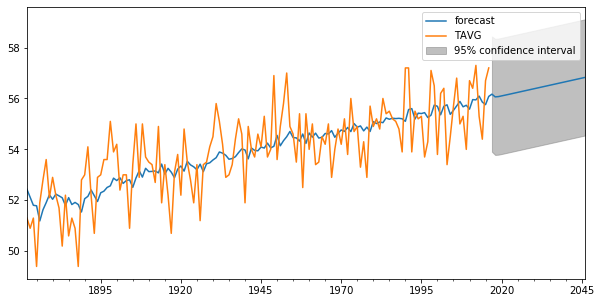

In [16]:
from statsmodels.tsa.arima_model import ARIMA

# Forecast temperatures using an ARIMA(1,1,1) model
mod = ARIMA(temp_NY, order=(1,1,1))
res = mod.fit()

# Plot the original series and the forecasted series
res.plot_predict(start='1872-01-01', end='2046-01-01');
plt.savefig('../images/tavg_predict.png')